# Conducting necessary reviews for feature selection and engineering 

In [7]:
import pandas as pd
import json


with open('dataset.json', 'r') as file:
    data = json.load(file)

# transform to dataframe
df = pd.DataFrame(data['data'])

# Helpful sütunlarını ayrıştırma
df['helpful_votes'] = df['helpful'].apply(lambda x: int(x[1:-1].split(', ')[0]))
df['total_votes'] = df['helpful'].apply(lambda x: int(x[1:-1].split(', ')[1]))

# create percentage of helpfulness
df['helpful_percentage'] = df.apply(lambda row: row['helpful_votes'] / row['total_votes'] if row['total_votes'] > 0 else 0, axis=1)


print(df[['helpful', 'helpful_votes', 'total_votes', 'helpful_percentage']].head())


  helpful  helpful_votes  total_votes  helpful_percentage
0  [0, 0]              0            0                 0.0
1  [0, 0]              0            0                 0.0
2  [1, 1]              1            1                 1.0
3  [0, 0]              0            0                 0.0
4  [2, 2]              2            2                 1.0


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK packages for remove noises
nltk.download('stopwords')
nltk.download('punkt')

# Text Cleaner
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punct
    text = text.lower()  
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in stop_words])  # remove stopwords
    return text

# new dataset
df['cleaned_text'] = df['reviewText'].apply(clean_text) + ' ' + df['summary'].apply(clean_text)

# Temizlenmiş metin ve helpful yüzdesini görüntüleme
print(df[['cleaned_text', 'helpful_percentage', 'rating']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\90506\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\90506\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        cleaned_text  helpful_percentage  \
0  great story line slow going first bad kept int...                 0.0   
1  rushed story skips ahead fast things explained...                 0.0   
2  lot history two meet gets hot hurry good book ...                 1.0   
3  great fun read right length relaxing getting i...                 0.0   
4  gave book 3 stars simply writing little awkwar...                 1.0   

   rating  
0       5  
1       2  
2       5  
3       5  
4       3  


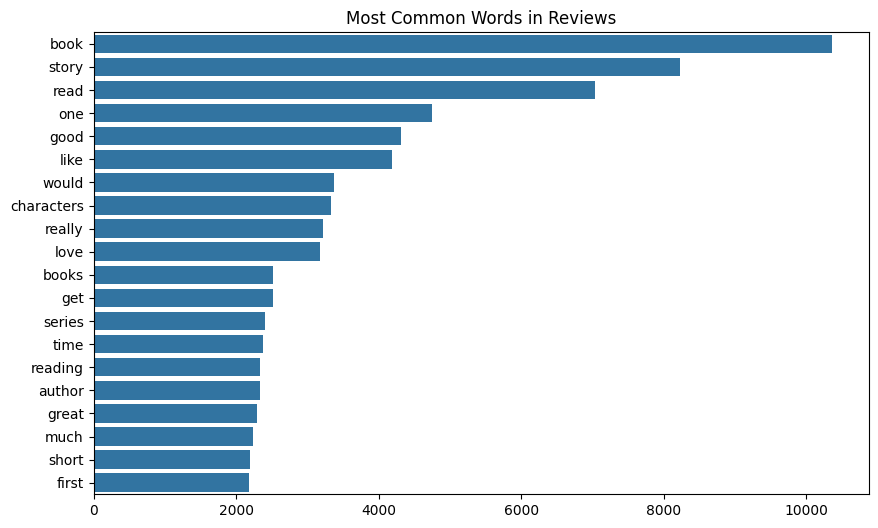

In [9]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


all_text = ' '.join(df['cleaned_text'])


word_counts = Counter(all_text.split())

# check common words
common_words = word_counts.most_common(20)

# see freq
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words in Reviews')
plt.show()


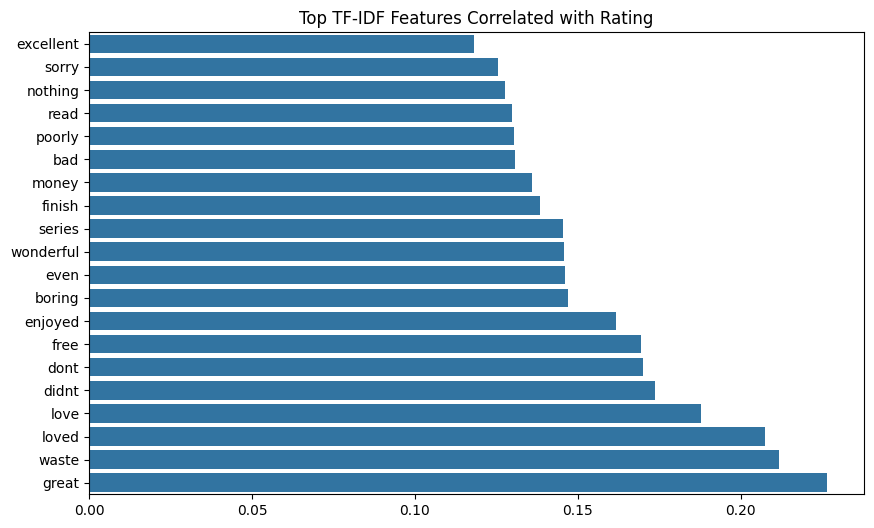

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF 
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])

# TF-IDF vektörleri ile rating arasındaki korelasyonu hesaplama
correlations = []
for i in range(X_tfidf.shape[1]):
    correlation = np.corrcoef(X_tfidf[:, i].toarray().flatten(), df['rating'])[0, 1]
    correlations.append(correlation)


top_n = 20
top_indices = np.argsort(np.abs(correlations))[-top_n:]
top_features = np.array(vectorizer.get_feature_names_out())[top_indices]
top_correlations = np.array(correlations)[top_indices]

# plot top 20 corellation
plt.figure(figsize=(10, 6))
sns.barplot(x=np.abs(top_correlations), y=top_features)
plt.title('Top TF-IDF Features Correlated with Rating')
plt.show()


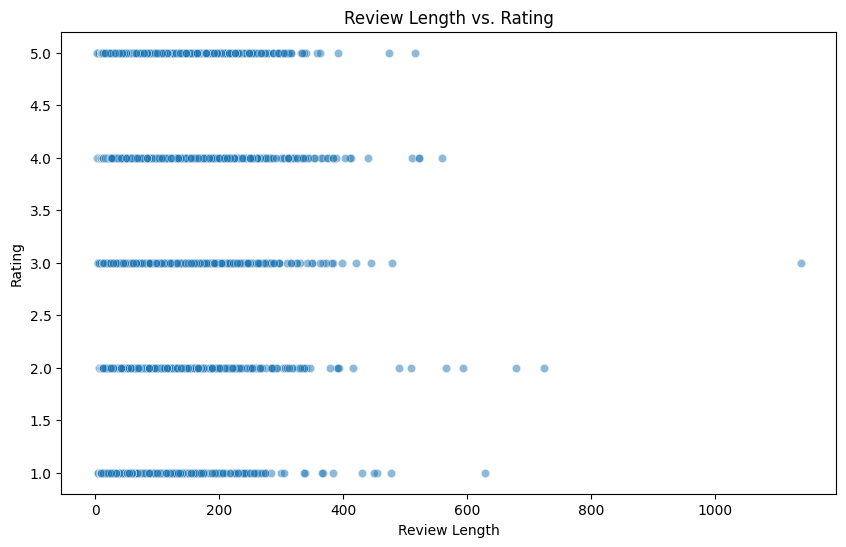

In [12]:

df['review_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='rating', data=df, alpha=0.5)
plt.title('Review Length vs. Rating')
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.show()


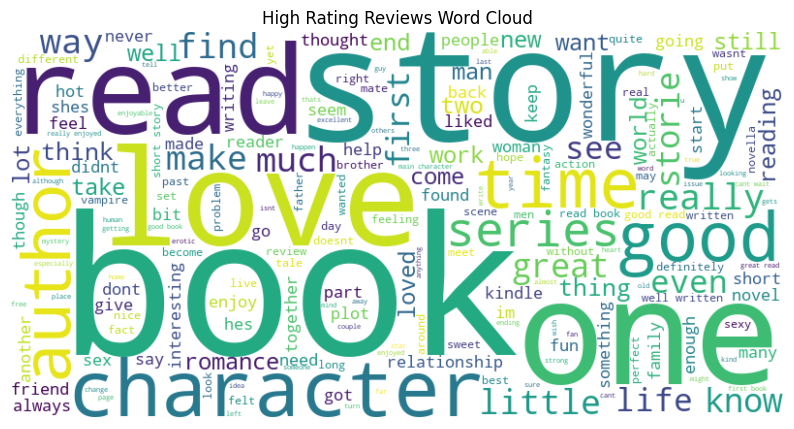

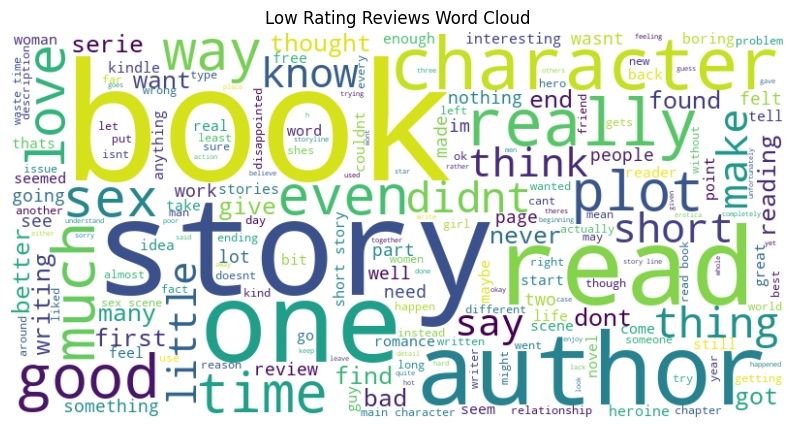

In [13]:
from wordcloud import WordCloud


high_rating_text = ' '.join(df[df['rating'] >= 4]['cleaned_text'])
high_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(high_rating_text)

plt.figure(figsize=(10, 6))
plt.imshow(high_wordcloud, interpolation='bilinear')
plt.title('High Rating Reviews Word Cloud')
plt.axis('off')
plt.show()


low_rating_text = ' '.join(df[df['rating'] <= 2]['cleaned_text'])
low_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(low_rating_text)

plt.figure(figsize=(10, 6))
plt.imshow(low_wordcloud, interpolation='bilinear')
plt.title('Low Rating Reviews Word Cloud')
plt.axis('off')
plt.show()


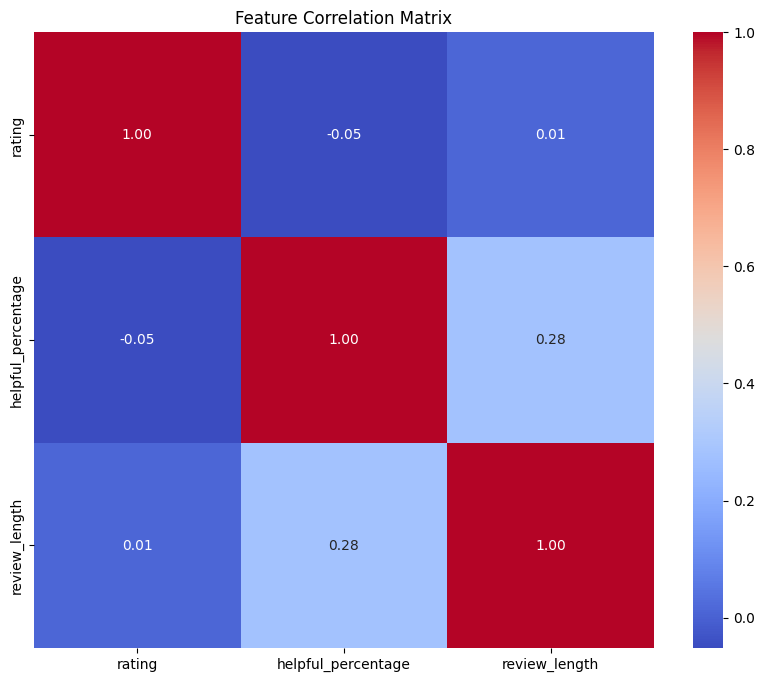

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisi
correlation_matrix = df[['rating', 'helpful_percentage', 'review_length']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


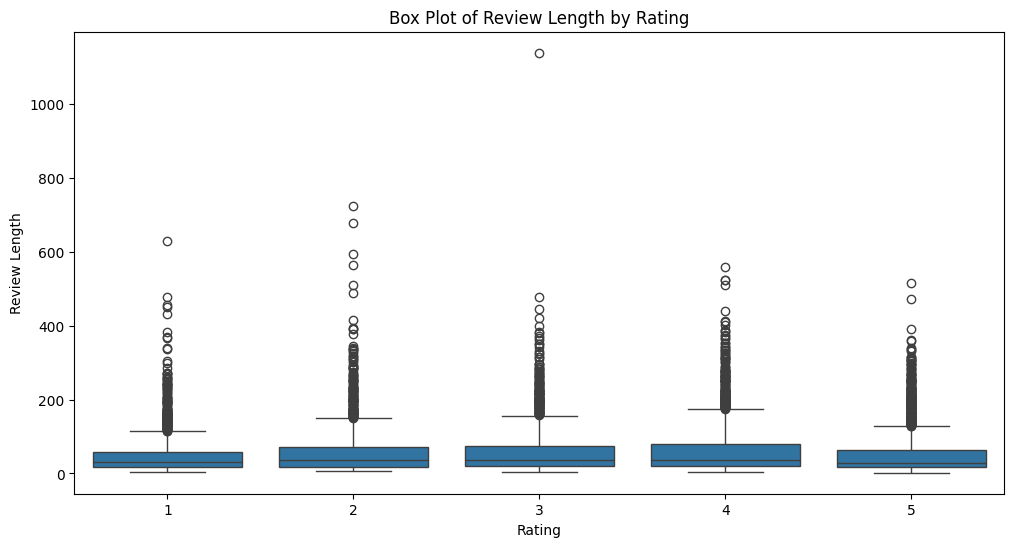

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rating', y='review_length')
plt.title('Box Plot of Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.show()


C:\Users\90506\AppData\Local\Temp\ipykernel_110136\2450956774.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


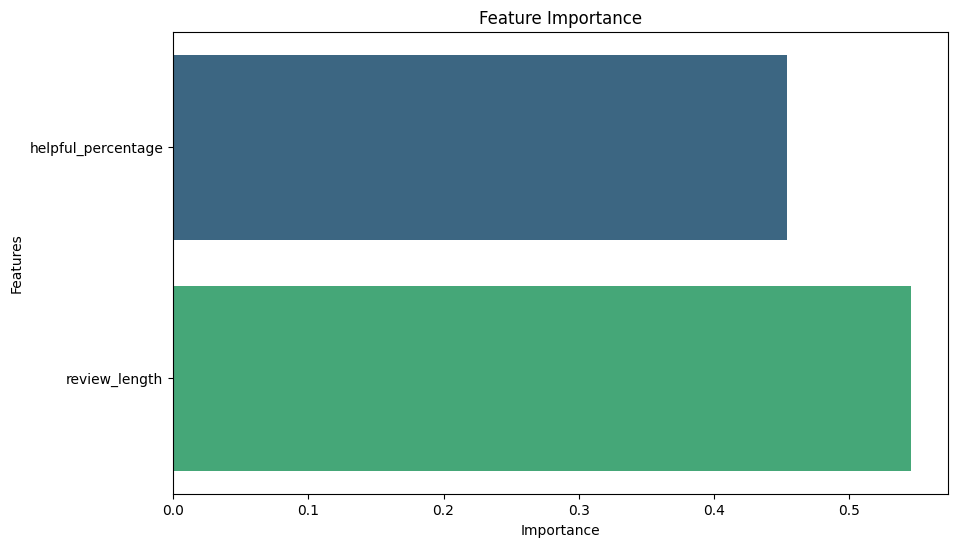

In [16]:
from sklearn.ensemble import RandomForestRegressor

X = df[['helpful_percentage', 'review_length']]
y = df['rating']


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
features = ['helpful_percentage', 'review_length']

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [17]:
import re

# For removing noises
contractions_dict = {
    "can't": "cannot",
    "won't": "will not",
    "I'm": "I am",
    "you're": "you are",
    "it's": "it is",
    "don't": "do not",
    "didn't": "did not",
    "couldn't": "could not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "I've": "I have",
    "we've": "we have",
    "they've": "they have",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would"
}

# expand
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) if contractions_dict.get(match) else contractions_dict.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text


df['expanded_text'] = df['cleaned_text'].apply(lambda x: expand_contractions(x, contractions_dict))

print(df[['cleaned_text', 'expanded_text']].head())


                                        cleaned_text  \
0  great story line slow going first bad kept int...   
1  rushed story skips ahead fast things explained...   
2  lot history two meet gets hot hurry good book ...   
3  great fun read right length relaxing getting i...   
4  gave book 3 stars simply writing little awkwar...   

                                       expanded_text  
0  great story line slow going first bad kept int...  
1  rushed story skips ahead fast things explained...  
2  lot history two meet gets hot hurry good book ...  
3  great fun read right length relaxing getting i...  
4  gave book 3 stars simply writing little awkwar...  


In [11]:
import nltk
from nltk.stem import WordNetLemmatizer

# NLTK lemmatizer and WordNet
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Lemmatization
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text

# apply lemmatization
df['lemmatized_text'] = df['expanded_text'].apply(lemmatize_text)


print(df[['expanded_text', 'lemmatized_text']].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\90506\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                       expanded_text  \
0  great story line slow going first bad kept int...   
1  rushed story skips ahead fast things explained...   
2  lot history two meet gets hot hurry good book ...   
3  great fun read right length relaxing getting i...   
4  gave book 3 stars simply writing little awkwar...   

                                     lemmatized_text  
0  great story line slow going first bad kept int...  
1  rushed story skip ahead fast thing explained p...  
2  lot history two meet get hot hurry good book s...  
3  great fun read right length relaxing getting i...  
4  gave book 3 star simply writing little awkward...  


In [13]:
# Tüm metin verilerini BERT ile vektörleştirme
def encode_texts(texts):
    encoded_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        encoded_texts.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return encoded_texts

# DataFrame'deki expanded metin sütununu vektörleştirme
df['bert_vectors'] = encode_texts(df['lemmatized_text'].tolist())

# check head
print(df[['lemmatized_text', 'bert_vectors']].head())


                                     lemmatized_text  \
0  great story line slow going first bad kept int...   
1  rushed story skip ahead fast thing explained p...   
2  lot history two meet get hot hurry good book s...   
3  great fun read right length relaxing getting i...   
4  gave book 3 star simply writing little awkward...   

                                        bert_vectors  
0  [-0.13253239, -0.546789, 0.86016273, 0.1189642...  
1  [0.3062793, -0.10020138, 0.37504598, 0.1178921...  
2  [0.13137284, -0.26687902, 0.662676, 0.06235883...  
3  [0.34083474, -0.10212354, 0.51236373, 0.004876...  
4  [-0.099174425, -0.15148644, 0.60178787, -0.033...  


## Preparing features


In [6]:
# calculate helpful rate
def calculate_helpful_ratio(helpful):
    try:
        helpful_list = eval(helpful)
        if helpful_list[1] == 0:
            return 0
        else:
            return helpful_list[0] / helpful_list[1]
    except:
        return 0

# Preparing features

X = np.array(df['bert_vectors'].tolist())
helpful_percentages = df['helpful_percentage'].values.reshape(-1, 1)
review_lengths = df['review_length'].values.reshape(-1, 1)

# BERT vektörlerini, helpful yüzdesini ve review uzunluğunu birleştirme
X = np.hstack((X, helpful_percentages, review_lengths))

y = df['rating'].values

# Eğitim ve test verilerini ayırma
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



NameError: name 'df' is not defined

###                                                           Creating model

In [5]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pickle

# prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Early stopping for overfit
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# creating model parameter
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))


# compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# training with earlystop
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Kfold cross validation
kf = KFold(n_splits=5)
val_mae = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # recreate model
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_fold.shape[1], activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    # train
    model.fit(X_train_fold, y_train_fold, epochs=500, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)
    
    # check MAE
    y_pred = model.predict(X_val_fold)
    val_mae.append(mean_absolute_error(y_val_fold, y_pred))

# avarage MAE
print(f"Ortalama MAE: {np.mean(val_mae)}")

# save as pck
with open('rating_predictor.pkl', 'wb') as file:
    pickle.dump(model, file)


NameError: name 'X' is not defined

In [4]:
import pandas as pd

# Performans değerlendirme sonuçları
performance_data = {
    "Model": ["Keras Dense Model"],
    "RMSE": [np.mean(val_mae)],
    "Training Time (Epochs)": ["100"]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)

NameError: name 'val_mae' is not defined

In [2]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pickle

app = FastAPI()

# Pydantic model
class Review(BaseModel):
    review_text: str
    summary: str
    helpful_ratio: float

# Model and tokenizer
with open('rating_predictor.pkl', 'rb') as file:
    model = pickle.load(file)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldırma
    text = text.lower()  # Küçük harfe çevirme
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in stop_words])  # Stopwords kaldırma
    return text

def encode_text(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy().squeeze()

@app.post("/predict")
def predict(review: Review):
    try:
        print("Request received")
        cleaned_text = clean_text(review.review_text + ' ' + review.summary)
        print(f"Cleaned text: {cleaned_text}")
        bert_vector = encode_text(cleaned_text)
        print(f"BERT vector shape: {bert_vector.shape}")
        bert_vector = bert_vector.reshape(1, -1)  # Tek boyutlu BERT vektörünü iki boyutluya dönüştür
        print(f"Reshaped BERT vector shape: {bert_vector.shape}")
        features = np.hstack((bert_vector, np.array([[review.helpful_ratio, len(cleaned_text.split())]])))
        print(f"Features shape: {features.shape}")
        prediction = model.predict(features)[0]
        print(f"Prediction: {prediction}")
        return {"predicted_rating": float(prediction)}
    except Exception as e:
        print(f"Error: {e}")
        raise HTTPException(status_code=500, detail=str(e))



#check http://localhost:8000/predict on postman
import nest_asyncio
nest_asyncio.apply()

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

INFO:     127.0.0.1:55898 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:55898 - "GET /favicon.ico HTTP/1.1" 404 Not Found
Request received
Cleaned text: love reading things involving 16th presidenti got learn enjoy reading would suggest othersit gets reader wonderful stories
BERT vector shape: (768,)
Reshaped BERT vector shape: (1, 768)
Features shape: (1, 770)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction: [4.610713]
INFO:     127.0.0.1:56023 - "POST /predict HTTP/1.1" 200 OK


C:\Users\90506\AppData\Local\Temp\ipykernel_110136\4269688286.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"predicted_rating": float(prediction)}
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [110136]


KeyboardInterrupt: 

In [3]:
import unittest
from fastapi.testclient import TestClient

class APITestCase(unittest.TestCase):

    def setUp(self):
        self.client = TestClient(app)

    def test_predict(self):
        response = self.client.post("/predict", json={
            "review_text": "This is a great product. I really enjoyed using it!",
            "summary": "Great product",
            "helpful_ratio": 0.8
        })
        self.assertEqual(response.status_code, 200)
        self.assertIn("predicted_rating", response.json())

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


Request received
Cleaned text: great product really enjoyed using great product
BERT vector shape: (768,)
Reshaped BERT vector shape: (1, 768)
Features shape: (1, 770)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\90506\AppData\Local\Temp\ipykernel_110136\4269688286.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"predicted_rating": float(prediction)}
.
----------------------------------------------------------------------
Ran 1 test in 0.152s

OK


Prediction: [4.3577223]
